In [1]:
import math
import numpy as np
import pandas as pd
from scipy.spatial import KDTree
from scipy.stats import norm
from scipy.stats import multivariate_normal as m_norm
from sklearn.neighbors import KernelDensity
import pickle
import seaborn as sns

from matplotlib import pyplot as plt
PATH = '../data/' # '/kaggle/input/nfl-big-data-bowl-2020/'
%matplotlib inline

In [2]:
from sklearn.model_selection import KFold, TimeSeriesSplit
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import Ridge
import lightgbm as lgb

# Functions and classes

## Preprocessing

In [56]:
def preprocess(df, is_train=True):
    ## keep only important columns
    cols_to_drop = ['GameId', 'DisplayName', 'JerseyNumber', 'Quarter', 'GameWeather', 'Turf', 
                    'GameClock', 'Dis', 'TimeHandoff', 'PlayerBirthDate', 
                    'HomeScoreBeforePlay', 'VisitorScoreBeforePlay', 'OffensePersonnel', 'OffenseFormation', 
                    'DefensePersonnel', 'TimeSnap', 'PlayerCollegeName', 'Stadium', 'Location', 
                    'StadiumType', 'Temperature', 'Humidity', 'WindSpeed', 'WindDirection']
    df.drop(cols_to_drop, axis=1, inplace=True)
    
    if is_train:
        ## Adjust speed in 2017
        S_17_std = (df[df.Season == 2017].S - df[df.Season == 2017].S.mean())/df[df.Season == 2017].S.std()
        df.loc[df.Season == 2017, 'S'] = S_17_std * df[df.Season == 2018].S.std() + df[df.Season == 2018].S.mean()
    
        ## Adjust acceleration in 2018
        A_17_std = (df[df.Season == 2017].A - df[df.Season == 2017].A.mean())/df[df.Season == 2017].A.std()
        df.loc[df.Season == 2017, 'A'] = A_17_std * df[df.Season == 2018].A.std() + df[df.Season == 2018].A.mean()

    
    
    ## Fix abbreviations
    df.loc[df.HomeTeamAbbr == "ARI", 'HomeTeamAbbr'] = "ARZ"
    df.loc[df.HomeTeamAbbr == "BAL", 'HomeTeamAbbr'] = "BLT"
    df.loc[df.HomeTeamAbbr == "CLE", 'HomeTeamAbbr'] = "CLV"
    df.loc[df.HomeTeamAbbr == "HOU", 'HomeTeamAbbr'] = "HST"
    
    df.loc[df.VisitorTeamAbbr == "ARI", 'VisitorTeamAbbr'] = "ARZ"
    df.loc[df.VisitorTeamAbbr == "BAL", 'VisitorTeamAbbr'] = "BLT"
    df.loc[df.VisitorTeamAbbr == "CLE", 'VisitorTeamAbbr'] = "CLV"
    df.loc[df.VisitorTeamAbbr == "HOU", 'VisitorTeamAbbr'] = "HST"
    
    # Is player on offense or not?
    df['ToLeft'] = df.PlayDirection == "left"
    df['IsBallCarrier'] = df.NflId == df.NflIdRusher
    df['TeamOnOffense'] = "home"
    df.loc[df.PossessionTeam != df.HomeTeamAbbr, 'TeamOnOffense'] = "away"
    df['IsOnOffense'] = df.Team == df.TeamOnOffense
    df['OffenseTeamName'] = np.where(df.TeamOnOffense == 'home', 
                                     df.HomeTeamAbbr, df.VisitorTeamAbbr)
    df['DefenseTeamName'] = np.where(df.TeamOnOffense == 'away', 
                                     df.HomeTeamAbbr, df.VisitorTeamAbbr)

    ## fix YardLine 
    df['YardLine_std'] = 100 - df.YardLine
    cond = df.FieldPosition.fillna('') == df.PossessionTeam
    df.loc[cond, 'YardLine_std'] = df.loc[cond, 'YardLine']

    ## fix X, Y
    df['X_std'] = df.X
    df.loc[df.ToLeft, 'X_std'] = 120 - df.loc[df.ToLeft, 'X'] 
    df['Y_std'] = df.Y
    df.loc[df.ToLeft, 'Y_std'] = 160/3 - df.loc[df.ToLeft, 'Y'] 

    ## fix Dir
    df['Dir_rad'] = np.mod(90 - df.Dir, 360) * math.pi/180.0 
    df['Dir_std'] = df.Dir_rad
    df.loc[df.ToLeft, 'Dir_std'] = np.mod(np.pi + df.loc[df.ToLeft, 'Dir_rad'], 2*np.pi)

    ## fix Orientation
    df['Orientation_rad'] = np.mod(df.Orientation, 360) * math.pi/180.0
    df.loc[df.Season >= 2018, 
           'Orientation_rad'] = np.mod(df.loc[df.Season >= 2018, 'Orientation'] - 90, 360) * math.pi/180.0
    df['Orientation_std'] = df.Orientation_rad
    df.loc[df.ToLeft, 'Orientation_std'] = np.mod(np.pi + df.loc[df.ToLeft, 'Orientation_rad'], 2*np.pi)

    ## drop unnesessary columns
    cols_to_drop = ['PlayDirection', 'NflId', 'NflIdRusher', 'FieldPosition', 
                    'Team', 'PossessionTeam', 'HomeTeamAbbr', 'VisitorTeamAbbr', 'TeamOnOffense', 'ToLeft', 
                    'YardLine', 'X', 'Y', 'Dir', 'Dir_rad', 'Orientation', 'Orientation_rad']
    df.drop(cols_to_drop, axis=1, inplace=True)
    
    ## fill NaNs
    for col in ['DefendersInTheBox', 'Dir_std', 'Orientation_std']:
        df[col].fillna(df[col].median(), inplace=True)
    return df

## FE

In [4]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [5]:
def get_influence_radius(dist, min_rad=4, max_rad=10, dist_threshold=20):
    if dist <= dist_threshold:
        return min_rad + (max_rad - min_rad) * (dist/dist_threshold)**2
    else:
        return max_rad

In [6]:
def get_player_influence(row, row_rusher, delta_t=1, S_max=10, eps=1e-6):
    ## calc distribution mean
    mean = [row.X_std + delta_t * row.S * np.cos(row.Dir_std)/2, 
            row.Y_std + delta_t * row.S * np.sin(row.Dir_std)/2]
    
    ## calc distribution covariance matrix
    dist_to_rusher = np.sqrt((row.X_std - row_rusher.X_std)**2 + (row.Y_std - row_rusher.Y_std)**2)
    inf_radius = get_influence_radius(dist_to_rusher)
    R = np.array([[np.cos(row.Dir_std), -np.sin(row.Dir_std)], 
                  [np.sin(row.Dir_std), np.cos(row.Dir_std)]])
    S = np.array([[inf_radius * (1 + (row.S/S_max)**2)/2, 0], 
                  [0, inf_radius * (1 - (row.S/S_max)**2)/2]])
    cov = np.dot(np.dot(R, S), np.dot(S, np.linalg.inv(R)))
    
    ## calc and return normed pdf
    denom = m_norm.pdf([row.X_std, row.Y_std], mean=mean, cov=cov)
    influence = lambda x: m_norm.pdf(x, mean=mean, cov=cov)/(denom + eps)
    return influence 

In [7]:
def get_pitch_control(df_play, delta_t=1, no_offense=False, no_rusher=False):
    row_rusher = df_play[df_play.IsBallCarrier].iloc[0]
    
    ## get offense influences
    get_inf = lambda row: get_player_influence(row, row_rusher, delta_t=delta_t)
    offense_infs = []
    if no_offense == False:
        offense_infs = list(df_play[(df_play.IsOnOffense) & 
                                    (df_play.IsBallCarrier == False)].apply(get_inf, axis=1).values)
    if no_rusher == False:
        offense_infs.append(get_player_influence(row_rusher, row_rusher, delta_t=delta_t))
            
    defense_infs = df_play[df_play.IsOnOffense == False].apply(get_inf, axis=1).values 
    
    pc = lambda x: sigmoid(sum([inf(x) for inf in offense_infs]) 
                                     - sum([inf(x) for inf in defense_infs]))
    return pc

In [8]:
def get_point_pc(row_rusher, point_type):
    if point_type == 'rusher_pose':
        point = (row_rusher.X_std, row_rusher.Y_std)
    elif point_type == 'ifo_rusher':
        point = (row_rusher.X_std + row_rusher.S * np.cos(row_rusher.Dir_std), 
                 row_rusher.Y_std + row_rusher.S * np.sin(row_rusher.Dir_std))
    else:
        return -1
    return row_rusher.pitch_control(point)

## Modelling

In [9]:
## Model fits on number of yards (as regressor) 
## and predicts proba density for each yard from -99 to 99 (as multiclassifier)

class ConditionalRegressor:
    def __init__(self, model, num_percentiles=10, 
                 kde=KernelDensity(kernel='exponential', metric='manhattan', bandwidth=0.3), 
                 cv_iter=5, 
                 window=0):
        self.model = model
        self.num_percentiles = num_percentiles
        self.kde = kde
        self.cv_iter = cv_iter
        self.window = window
        
    def get_cv_predictions(self, X, y):
        cv = KFold(n_splits=self.cv_iter, shuffle=False)
        y_pred = np.zeros(X.shape[0]) 
        for tr_index, val_index in cv.split(X):
            self.model.fit(X[tr_index], y[tr_index])
            y_pred[val_index] = self.model.predict(X[val_index])
        return y_pred
    
    def bin_predictions(self, pred):
        return np.sum([pred > pct for pct in self.percentiles], axis=0)
    
    def fit(self, X, y):
        ## train regressor on log(y)
        y_log = np.where(y >= 0, np.log(1 + np.abs(y)), -np.log(1 + np.abs(y)))
        pred = self.get_cv_predictions(X, y_log)
        self.model.fit(X, y_log)
        
        ## bin cv predictions
        self.percentiles = np.percentile(pred, np.linspace(1, 99, self.num_percentiles))
        pred_binned = self.bin_predictions(pred)
        
        ## calc distribution for each bin
        self.distribution = {}
        for interval in range(self.num_percentiles + 1):
            filt = [abs(interval - x) <= self.window for x in pred_binned]
            if sum(filt) == 0:
                filt = [True for x in pred_binned]
            self.kde.fit(y[filt, np.newaxis])
            self.distribution[interval] = np.exp(self.kde.score_samples(np.arange(-99, 100)[:, np.newaxis]))
            self.distribution[interval] /= sum(self.distribution[interval])
    
    def plot_importances(self, column_names, importances=[], h_size=15, v_size=20):
        FI = pd.DataFrame()
        FI["names"] = column_names
        if len(importances) == 0:
            FI["importances"] = self.model.feature_importances_
        else:
            FI["importances"] = importances
        plt.figure(figsize=(h_size, v_size))
        sns.barplot(data=FI.sort_values(by="importances", ascending=False), 
                    x="importances", y="names")
        plt.title("Feature importances")
    
    def predict_proba(self, X):
        pred = self.model.predict(X)
        pred_binned = self.bin_predictions(pred)
        return np.array([self.distribution[x] for x in pred_binned])

In [10]:
def srps_score(y_true, y_pred):
    score = 0
    y_pred_cumsum = np.cumsum(y_pred, axis=1)
    for n in range(199):
         score += ((y_pred_cumsum[:, n] - np.where(n - 99 >= y_true, 1, 0))**2).sum()
    return score/(199 * len(y_true))

In [11]:
def evaluate_model(model, df, features, print_process=True, 
                   cv_type='last_year', n_splits=5):
    scores = []
    if cv_type == 'last_year':
        X_train = df.loc[df.Season == 2017, features].values
        y_train = df.loc[df.Season == 2017, 'Yards'].values
        model.fit(X_train, y_train)
        for week in range(df.Week.min(), df.Week.max() + 1):
            X_valid = df.loc[(df.Season == 2018) & (df.Week == week), 
                             features].values
            y_valid = df.loc[(df.Season == 2018) & (df.Week == week), 
                             'Yards'].values
            y_pred = model.predict_proba(X_valid)
            score = srps_score(y_valid, y_pred)
            if print_process:
                print("SRPS =", score, " on week", week)
            scores.append(score)
    elif cv_type == 'tss':
        X_17 = df.loc[df.Season == 2017, features].values
        y_17 = df.loc[df.Season == 2017, 'Yards'].values
        X_18 = df.loc[df.Season == 2018, features].values
        y_18 = df.loc[df.Season == 2018, 'Yards'].values
        cv = TimeSeriesSplit(n_splits=n_splits)
        cnt = 1
        for tr_index, val_index in cv.split(X_18):
            model.fit(np.vstack((X_17, X_18[tr_index])), 
                      np.hstack((y_17, y_18[tr_index])))
            y_pred = model.predict_proba(X_18[val_index])
            score = srps_score(y_18[val_index], y_pred)
            if print_process:
                print("SRPS =", score, " on fold", cnt)
            scores.append(score)
            cnt += 1
            
    scores = np.array(scores)
    if print_process:
        print("Mean SRPS:", scores.mean())
        print("Std of SRPS:", scores.std())
    return scores

In [12]:
def plot_custom_importances(model, df, features, scores=[], v_size=5, cv_type='last_year'):
    ## Calc score with every feature
    if len(scores) == 0:
        scores_with = evaluate_model(model, df, features, print_process=False, 
                                     cv_type=cv_type)
    else:
        scores_with = np.array(scores)
        
    # Calc score without fixed feature
    importances = []
    for col in features:
        other_features = list(features)
        other_features.remove(col)
        scores_without = evaluate_model(model, df, other_features, print_process=False, 
                                        cv_type=cv_type)
        scores_diff = scores_without - scores_with
        importances.append(scores_diff.mean())
        
    # plot importances
    model.plot_importances(features, importances=importances, v_size=v_size)

# Preprocessing

In [57]:
%%time
df = pd.read_csv(PATH + 'train.csv', low_memory=False)
df = preprocess(df)
df.to_csv('../data/train_preprocessed.csv', index=False)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 509762 entries, 0 to 509761
Data columns (total 21 columns):
PlayId               509762 non-null int64
S                    509762 non-null float64
A                    509762 non-null float64
Season               509762 non-null int64
Down                 509762 non-null int64
Distance             509762 non-null int64
DefendersInTheBox    509762 non-null float64
Yards                509762 non-null int64
PlayerHeight         509762 non-null object
PlayerWeight         509762 non-null int64
Position             509762 non-null object
Week                 509762 non-null int64
IsBallCarrier        509762 non-null bool
IsOnOffense          509762 non-null bool
OffenseTeamName      509762 non-null object
DefenseTeamName      509762 non-null object
YardLine_std         509762 non-null int64
X_std                509762 non-null float64
Y_std                509762 non-null float64
Dir_std              509762 non-null float64
Orientation_std

In [58]:
df_play = df[df.IsBallCarrier].drop(['IsOnOffense', 'IsBallCarrier'], axis=1)
df_play.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23171 entries, 18 to 509761
Data columns (total 19 columns):
PlayId               23171 non-null int64
S                    23171 non-null float64
A                    23171 non-null float64
Season               23171 non-null int64
Down                 23171 non-null int64
Distance             23171 non-null int64
DefendersInTheBox    23171 non-null float64
Yards                23171 non-null int64
PlayerHeight         23171 non-null object
PlayerWeight         23171 non-null int64
Position             23171 non-null object
Week                 23171 non-null int64
OffenseTeamName      23171 non-null object
DefenseTeamName      23171 non-null object
YardLine_std         23171 non-null int64
X_std                23171 non-null float64
Y_std                23171 non-null float64
Dir_std              23171 non-null float64
Orientation_std      23171 non-null float64
dtypes: float64(7), int64(8), object(4)
memory usage: 3.5+ MB


# Feature engineering

### Situation-based

In [59]:
%%time
g = df.groupby('PlayId').apply(lambda df: get_pitch_control(df, no_rusher=True))
df_play['pitch_control'] = df_play.PlayId.map(g)

CPU times: user 7min 50s, sys: 2min 17s, total: 10min 8s
Wall time: 5min 5s


In [60]:
%%time
df_play['ifo_rusher_pc'] = df_play.apply(lambda row: get_point_pc(row, point_type='ifo_rusher'), 
                                          axis=1)

CPU times: user 50.1 s, sys: 644 ms, total: 50.7 s
Wall time: 49.7 s


In [82]:
df_play['rusher_speed_x'] = df_play.S * np.cos(df_play.Dir_std)
df_play['rusher_speed_y'] = np.abs(df_play.S * np.sin(df_play.Dir_std))

In [109]:
def get_distance(row_rusher, row):
    return np.sqrt((row_rusher.X_std - row.X_std)**2 + (row_rusher.Y_std - row.Y_std)**2)

In [215]:
def get_distances_stat(play):
    row_rusher = play[play.IsBallCarrier].iloc[0]
    offense_dists, defense_dists = [], []
    for index, row in play[play.IsBallCarrier == False].iterrows():
        if row.IsOnOffense:
            offense_dists.append(get_distance(row_rusher, row))
        else:
            defense_dists.append(get_distance(row_rusher, row))
    
    offense_dists = np.array(offense_dists)
    defense_dists = np.array(defense_dists)
    return pd.DataFrame(np.array([offense_dists.mean(), defense_dists.mean(), defense_dists.min()])[np.newaxis, :])

In [217]:
%%time
g = df.groupby('PlayId')['X_std', 'Y_std', 'IsBallCarrier', 
                         'IsOnOffense'].apply(get_distances_stat).set_index(df_play.index)
g.columns = ['offense_mean_dist', 'defense_mean_dist', 'defense_min_dist']

for col in g.columns:
    df_play[col] = g[col]

CPU times: user 1min 44s, sys: 358 ms, total: 1min 45s
Wall time: 1min 44s


### Teams and players

## Final features

In [218]:
features = ['YardLine_std', 'DefendersInTheBox',  'ifo_rusher_pc', 
            'rusher_speed_x', 'rusher_speed_y'] + ['offense_mean_dist', 'defense_mean_dist', 'defense_min_dist']
df_play[features].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23171 entries, 18 to 509761
Data columns (total 8 columns):
YardLine_std         23171 non-null int64
DefendersInTheBox    23171 non-null float64
ifo_rusher_pc        23171 non-null float64
rusher_speed_x       23171 non-null float64
rusher_speed_y       23171 non-null float64
offense_mean_dist    23171 non-null float64
defense_mean_dist    23171 non-null float64
defense_min_dist     23171 non-null float64
dtypes: float64(7), int64(1)
memory usage: 1.6 MB


# Modelling

## Load evaluation result of previous solution

In [219]:
with open('../data/solution_score.pkl', 'rb') as fout:
    solution_scores = pickle.load(fout)
print('Previous score (x100) is', 100 * solution_scores['v1'].mean())

Previous score (x100) is 1.4350394020705597


## Evaluate model

In [239]:
lgb_regressor = lgb.LGBMRegressor(n_estimators=30, 
                                  learning_rate=0.1, 
                                  num_leaves=15,
                                  max_depth=6,
                                  min_child_weight=5,
                                  subsample=0.8,
                                  colsample_bytree=0.8,
                                  objective='mae',
                                  reg_alpha=0.5, 
                                  reg_lambda=0.5,
                                  random_state=42)

cond_regressor = ConditionalRegressor(lgb_regressor, num_percentiles=20, window=1)

In [240]:
%%time
scores = evaluate_model(cond_regressor, df_play, features, cv_type='tss', n_splits=5)

SRPS = 0.014662590619729207  on fold 1
SRPS = 0.013881566438259843  on fold 2
SRPS = 0.014727235212198585  on fold 3
SRPS = 0.01441517283364353  on fold 4
SRPS = 0.013766496961898234  on fold 5
Mean SRPS: 0.014290612413145878
Std of SRPS: 0.0003966202639772986
CPU times: user 9.42 s, sys: 13.9 ms, total: 9.44 s
Wall time: 6.23 s


In [241]:
print("Mean score (x100) is", scores.mean() * 100)

Mean score (x100) is 1.4290612413145878


## Feature importances

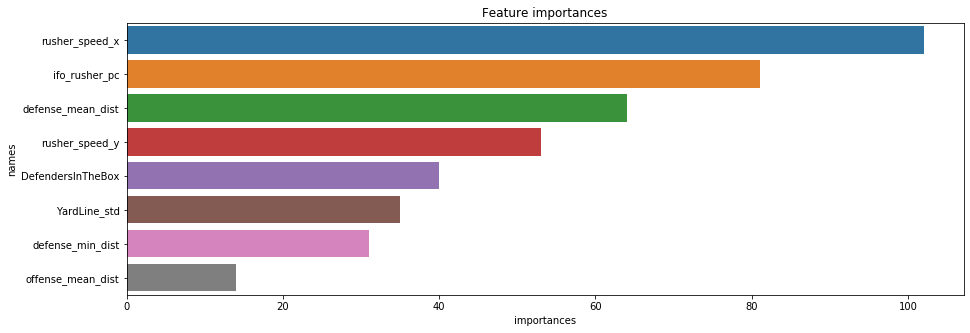

In [242]:
cond_regressor.plot_importances(features, v_size=5)

CPU times: user 1min 24s, sys: 234 ms, total: 1min 24s
Wall time: 56.3 s


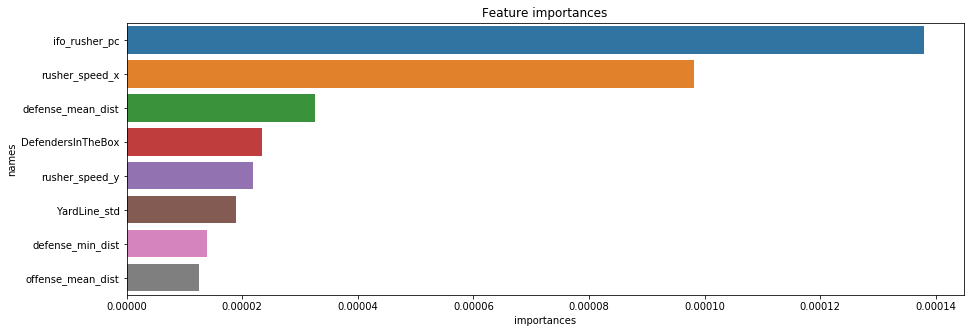

In [243]:
%%time
plot_custom_importances(cond_regressor, df_play, features, v_size=5, cv_type='tss')

## Save evaluation result

In [25]:
solution_scores['v2'] = scores
with open('../data/solution_score.pkl', 'wb') as fout:
    pickle.dump(solution_scores, fout, protocol=pickle.HIGHEST_PROTOCOL)
    
print("v1 score (x100) is better on", 100 * (solution_scores['v1'].mean() - scores.mean()), 
      'then v0 score (x100)')

v1 score (x100) is better on 0.0 then v0 score (x100)


## Fit model

In [168]:
%%time
X_train = df_play[features].values
y_train = df_play.Yards.values
cond_regressor.fit(X_train, y_train)

CPU times: user 2.29 s, sys: 19.7 ms, total: 2.31 s
Wall time: 760 ms


# Predict on test

In [ ]:
from kaggle.competitions import nflrush
env = nflrush.make_env()
columns = ['Yards' + str(i) for i in range(-99, 100)]

for df_test, _ in env.iter_test():
    ## preprocessing
    df_test = preprocess(df_test)
    df_play_test = df_test[df_test.IsBallCarrier].drop(['IsOnOffense', 'IsBallCarrier'], axis=1)
    
    ## FE
    g = df_test.groupby('PlayId').apply(lambda df: get_pitch_control(df, no_rusher=True))
    df_play_test['pitch_control'] = df_play_test.PlayId.map(g)
    df_play_test['ifo_rusher_pc'] = df_play_test.apply(lambda row: get_point_pc(row, point_type='ifo_rusher'), axis=1)
    df_play_test['rusher_speed_x'] = df_play_test.S * np.cos(df_play_test.Dir_std)
    df_play_test['rusher_speed_y'] = np.abs(df_play_test.S * np.sin(df_play_test.Dir_std))
    g = df_test.groupby('PlayId')['X_std', 'Y_std', 'IsBallCarrier', 
                         'IsOnOffense'].apply(get_distances_stat).set_index(df_play_test.index)
    g.columns = ['offense_mean_dist', 'defense_mean_dist', 'defense_min_dist']
    for col in g.columns:
        df_play_test[col] = g[col]
    
    ## predictions
    X_test = df_play_test[features].values
    y_pred = np.clip(np.cumsum(cond_regressor.predict_proba(X_test), axis=1), 0, 1)
    env.predict(pd.DataFrame(y_pred, columns=columns))
env.write_submission_file()